<a href="https://colab.research.google.com/github/aaaksenova/RuATD_katana/blob/change/RuATD_NNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN-LSTM-based models

In [1]:
import pandas as pd
import numpy as np
from torch.optim import RMSprop
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from string import punctuation
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
from tqdm.auto import tqdm
import random
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn import preprocessing

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [68]:
train_dataset = pd.read_csv('train.csv', ).iloc[:30000]
test_dataset = pd.read_csv('val.csv')

le = preprocessing.LabelEncoder()
le.fit(train_dataset.Class.unique())
train_dataset.Class = le.transform(train_dataset.Class)
test_dataset.Class = le.transform(test_dataset.Class)

In [69]:
train_dataset.iloc[:, 4:]

,flesch_kincaid_grade,flesch_reading_easy,coleman_liau_index,smog_index,automated_readability_index,lix,ttr,rttr,cttr,httr,sttr,mttr,dttr,mattr,msttr,mtld,mamtld,hdd,simpson_index,hapax_index
0,4.667500,53.697500,11.894000,12.553280,11.894000,70.500000,1.000000,2.828427,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.0,-1.000000,0.000,0.000000
1,5.014737,80.913947,4.601079,12.553280,4.601079,40.052632,0.947368,4.129483,2.919986,0.981638,0.924627,0.014360,69.639457,0.947368,0.947368,101.080000,1.0,-1.000000,171.000,2301.756482
2,1.920000,68.115000,2.914500,0.050000,2.914500,45.000000,1.000000,2.236068,1.581139,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.0,-1.000000,0.000,0.000000
3,12.911429,-16.907857,28.157786,17.732308,28.157786,107.000000,1.000000,2.645751,1.870829,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.0,-1.000000,0.000,0.000000
4,3.256923,78.981154,1.017269,8.891154,1.017269,59.153846,1.000000,3.605551,2.549510,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.0,-1.000000,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,19.818299,39.694278,10.185693,15.363328,10.185693,80.458763,0.886598,8.731977,6.174440,0.973689,0.961162,0.013243,75.512034,0.971250,0.920000,239.501818,1.0,0.949019,388.000,1708.623691
29996,17.721860,41.916395,8.827547,12.553280,8.827547,77.883721,0.813953,5.337450,3.774147,0.945270,0.885298,0.033506,29.845715,0.813953,0.813953,64.715000,1.0,-1.000000,112.875,714.642449
29997,-2.731429,111.877857,-5.825071,0.050000,-5.825071,21.285714,1.000000,2.645751,1.870829,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.0,-1.000000,0.000,0.000000
29998,20.077500,-7.552500,20.973500,30.676655,20.973500,94.500000,0.875000,4.949747,3.500000,0.961471,0.903909,0.025598,39.065363,0.875000,0.875000,71.680000,1.0,-1.000000,124.000,1053.604985


In [70]:
def preprocess(text):
    text = word_tokenize(text)
    return text

In [71]:
train_dataset['preprocessed_text'] = train_dataset['Text'].apply(lambda x: preprocess(x))
test_dataset['preprocessed_text'] = test_dataset['Text'].apply(lambda x: preprocess(x))

In [72]:
vocab = Counter()
for line in tqdm(train_dataset.preprocessed_text):
    vocab.update(line)

  0%|          | 0/30000 [00:00<?, ?it/s]

In [73]:
filtered_vocab = set()

for word in vocab.keys():
    if vocab[word] > 3:
        filtered_vocab.add(word)

In [74]:
word2id = {'UNK': 0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [75]:
MAX_LEN = 300

In [76]:
class MyDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['preprocessed_text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['Class'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = self.dataset[index] 
        ids = torch.LongTensor([self.word2id[token] if token in self.word2id \
                                else self.word2id['UNK'] for token in tokens][:MAX_LEN])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch): 
        ids, feats, y = list(zip(*batch))
        padded_ids = torch.LongTensor(torch.stack([F.pad(idx, (1, MAX_LEN - len(idx))) for idx in ids], dim=0)).to(self.device)
        y = torch.LongTensor(y).view(len(y)).to(self.device)
        return padded_ids, y

In [77]:
train_dataset = MyDataset(train_dataset, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=128)

In [78]:
test_dataset = MyDataset(test_dataset, word2id, DEVICE)
test_sampler = SequentialSampler(test_dataset)
test_iterator = DataLoader(test_dataset, collate_fn = test_dataset.collate_fn, sampler=test_sampler, batch_size=128)

## CNN 2/3/4

In [100]:
import numpy as np


# Я нашла код на тензорфлоу тут https://github.com/KifayatMsd/C-LSTM-text-classification/blob/master/clstm_classifier.py
class CNN_LSTM(nn.Module):
    """
    A CNN-LSTM classifier for text classification
    Reference: A C-LSTM Neural Network for Text Classification
    """

    def __init__(self, drop_first, max_length, filter_sizes, vocab_size):
        super().__init__()
        self.drop_first = drop_first  # Флажок, который показывает, делается ли дропаут первым или последним
        self.max_length = max_length  # Максимальная длина последовательности
        self.vocab_size = vocab_size  # Размер словаря
        self.filter_sizes = filter_sizes  # Список размеров фильтров

        self.embedding = nn.Embedding(vocab_size, 300)
        
        # Список сверток
        self.conv2 = nn.Conv1d(in_channels=310, out_channels=150, kernel_size=2)
        self.conv3 = nn.Conv1d(in_channels=310, out_channels=150, kernel_size=3)
        self.conv4 = nn.Conv1d(in_channels=310, out_channels=150, kernel_size=4)
        
        # Кладем в словарь нужные нам свертки
        self.convdict = {2 : self.conv2, 3 : self.conv3, 4 : self.conv4}
        

        self.lstm = nn.LSTM(input_size=150, hidden_size=150, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(p=0.5)
            
        # Активация и классификатор    
        self.relu = nn.ReLU()
        self.out = nn.Softmax(dim=1)
        self.linear = nn.Linear(150, 2)

    def forward(self, text):
        # batch_size x seq_len
        embedded = self.embedding(text)
        if self.drop_first:
            embedded = self.dropout(embedded)
        # batch_size x seq_len x embedding_dim
        embedded = emb_feats.transpose(1, 2)
        # batch_size x embedding_dim x seq_len

        max_feature_length = self.max_length - max(self.filter_sizes) + 1  # Обрезка по минимальной длине свертки
        conv_outputs = []
        for size in self.filter_sizes:
            layer = self.convdict[size]
            layer = layer(embedded)
            h = self.relu(layer)
            # Обрезка по последней размерности (длине аутпута)
            h = h[:, :, :max_feature_length]
            conv_outputs.append(h)
        if len(self.filter_sizes) > 1: # Если больше одной свертки, то конкатенируем, иначе возвращаем для одной свертки
            rnn_inputs = torch.cat(conv_outputs, -1)
        else:
            rnn_inputs = h
            
        # Прогоняем через ЛСТМ и классифицируем
        _, (hidden_state, _) = self.lstm(rnn_inputs.transpose(1, 2))
        if self.drop_first:
            embedded = self.dropout(embedded)
        logits = self.out(self.linear(torch.squeeze(hidden_state, 0)))
        
        return logits 

In [101]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [102]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs):
    set_random_seed(142)

    losses = []  # Лоссы по всем батчам трейна
    val_losses = [] # Лоссы по всем батчам теста
    val_losses_epoch = [] # Средний лосс эпохи теста
    val_acc = [] # Доля верных ответов по всем батчам теста
    val_acc_epoch = [] # Средняя доля верных ответов на эпохе теста

    print('Training ... ')
    for n_epoch in range(epochs):

        try:

            progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1), colour='green')
            model.train()
            for x, y in train_loader:

                optimizer.zero_grad()
                y_pred = model(x)
                loss = criterion(y_pred, y)
                loss.backward()  # считаем градиенты  
                optimizer.step()
                losses.append(loss.item())
                
                progress_bar.set_postfix(loss=np.mean(losses[-100:]))

                progress_bar.update(x.shape[0])

            progress_bar.close()


            if (n_epoch + 1) % 1 == 0:
                print('Validating ... ')
                progress_bar = tqdm(total=len(val_loader.dataset), desc='Epoch {}'.format(n_epoch + 1), colour='blue')
                val_loss = 0
                epoch_metric = 0
                model.eval() 
                with torch.no_grad():
                    for i, (texts, ys) in enumerate(val_loader):   
                        preds = model(texts)  # делаем предсказания на тесте
                        count_loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
                        val_acc.append(accuracy_score(torch.argmax(preds, dim=1).cpu().detach().numpy(), \
                                               ys.cpu().detach().numpy()))
                        epoch_metric += accuracy_score(torch.argmax(preds, dim=1).cpu().detach().numpy(), \
                                               ys.cpu().detach().numpy())
                        val_losses.append(count_loss.item())
                        val_loss += count_loss.item()
                        progress_bar.set_postfix(accuracy=np.mean(val_acc[-10:]), loss=np.mean(val_losses[-10:]))
                        progress_bar.update(texts.shape[0])
                val_acc_epoch.append(epoch_metric / len(val_loader))
                val_losses_epoch.append(val_loss / len(val_loader)) 
                progress_bar.close()
                if n_epoch + 1 < epochs:
                    print('Training ... ')
        except KeyboardInterrupt:

            progress_bar.close()
            break
    return losses, val_losses, val_losses_epoch, val_acc, val_acc_epoch

In [103]:
model = CNN_LSTM(0, MAX_LEN, [2, 3], len(word2id)) #drop_first, max_length, filter_sizes, vocab_size
model = model.to(DEVICE)
optimizer = RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(DEVICE)
losses, val_losses, val_losses_epoch, val_acc, val_acc_epoch = train(model, train_iterator, test_iterator, optimizer, criterion, 10)

Training ... 


Epoch 1:   0%|          | 0/30000 [00:00<?, ?it/s]

torch.Size([128, 301, 300])
torch.Size([128, 1, 10])


RuntimeError: ignored

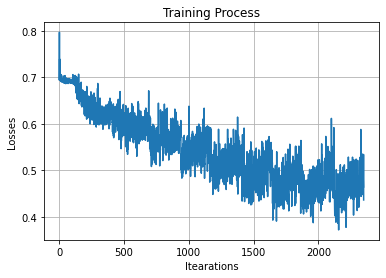

In [20]:
plt.title('Training Process')
plt.xlabel('Itearations')
plt.ylabel('Losses')
plt.grid()
plt.plot(losses)

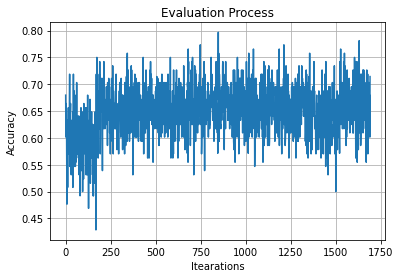

In [21]:
plt.title('Evaluation Process')
plt.xlabel('Itearations')
plt.ylabel('Accuracy')
plt.grid()
plt.plot(val_acc)

In [22]:
preds = []
true = []
for i, (texts, ys) in enumerate(test_iterator):   
    preds.extend(torch.argmax(model(texts), dim=1).cpu().detach().numpy())
    true.extend(ys.cpu().detach().numpy())
    
print(classification_report(true, preds))

              precision    recall  f1-score   support

           0       0.67      0.65      0.66     10756
           1       0.66      0.68      0.67     10755

    accuracy                           0.66     21511
   macro avg       0.66      0.66      0.66     21511
weighted avg       0.66      0.66      0.66     21511



In [23]:
import torch.optim as optim

In [24]:
model = CNN_LSTM(0, MAX_LEN, [2, 3, 4], len(word2id)) #drop_first, max_length, filter_sizes, vocab_size
model = model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(DEVICE)
losses, val_losses, val_losses_epoch, val_acc, val_acc_epoch = train(model, train_iterator, test_iterator, optimizer, criterion, 10)

Training ... 


Epoch 1:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 1:   0%|          | 0/21511 [00:00<?, ?it/s]

Training ... 


Epoch 2:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 2:   0%|          | 0/21511 [00:00<?, ?it/s]

Training ... 


Epoch 3:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 3:   0%|          | 0/21511 [00:00<?, ?it/s]

Training ... 


Epoch 4:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 4:   0%|          | 0/21511 [00:00<?, ?it/s]

Training ... 


Epoch 5:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 5:   0%|          | 0/21511 [00:00<?, ?it/s]

Training ... 


Epoch 6:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 6:   0%|          | 0/21511 [00:00<?, ?it/s]

Training ... 


Epoch 7:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 7:   0%|          | 0/21511 [00:00<?, ?it/s]

Training ... 


Epoch 8:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 8:   0%|          | 0/21511 [00:00<?, ?it/s]

Training ... 


Epoch 9:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 9:   0%|          | 0/21511 [00:00<?, ?it/s]

Training ... 


Epoch 10:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 10:   0%|          | 0/21511 [00:00<?, ?it/s]

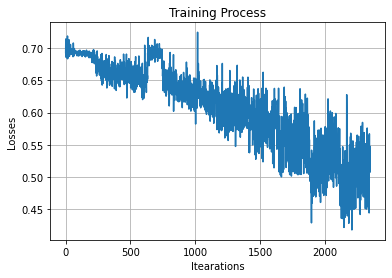

In [25]:
plt.title('Training Process')
plt.xlabel('Itearations')
plt.ylabel('Losses')
plt.grid()
plt.plot(losses)

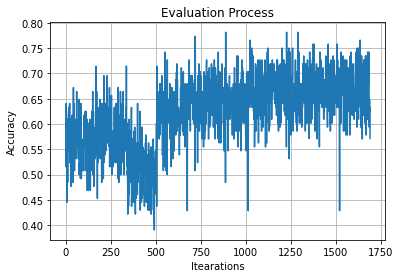

In [26]:
plt.title('Evaluation Process')
plt.xlabel('Itearations')
plt.ylabel('Accuracy')
plt.grid()
plt.plot(val_acc)

In [27]:
preds = []
true = []
for i, (texts, ys) in enumerate(test_iterator):   
    preds.extend(torch.argmax(model(texts), dim=1).cpu().detach().numpy())
    true.extend(ys.cpu().detach().numpy())
    
print(classification_report(true, preds))

              precision    recall  f1-score   support

           0       0.68      0.66      0.67     10756
           1       0.67      0.68      0.68     10755

    accuracy                           0.67     21511
   macro avg       0.67      0.67      0.67     21511
weighted avg       0.67      0.67      0.67     21511



In [ ]:
from torch.optim.lr_scheduler import ExponentialLR

In [ ]:
def train_scheduler(model, train_loader, val_loader, optimizer, criterion, epochs):
    set_random_seed(142)

    losses = []  # Лоссы по всем батчам трейна
    val_losses = [] # Лоссы по всем батчам теста
    val_losses_epoch = [] # Средний лосс эпохи теста
    val_acc = [] # Доля верных ответов по всем батчам теста
    val_acc_epoch = [] # Средняя доля верных ответов на эпохе теста

    print('Training ... ')
    for n_epoch in range(epochs):

        try:

            progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1), colour='green')
            model.train()
            for x, y in train_loader:

                optimizer.zero_grad()
                y_pred = model(x)
                loss = criterion(y_pred, y)
                loss.backward()  # считаем градиенты  
                optimizer.step()
                losses.append(loss.item())
                
                progress_bar.set_postfix(loss=np.mean(losses[-100:]))

                progress_bar.update(x.shape[0])

            progress_bar.close()
            scheduler.step()


            if (n_epoch + 1) % 1 == 0:
                print('Validating ... ')
                progress_bar = tqdm(total=len(val_loader.dataset), desc='Epoch {}'.format(n_epoch + 1), colour='blue')
                val_loss = 0
                epoch_metric = 0
                model.eval() 
                with torch.no_grad():
                    for i, (texts, ys) in enumerate(val_loader):   
                        preds = model(texts)  # делаем предсказания на тесте
                        count_loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
                        val_acc.append(accuracy_score(torch.argmax(preds, dim=1).cpu().detach().numpy(), \
                                               ys.cpu().detach().numpy()))
                        epoch_metric += accuracy_score(torch.argmax(preds, dim=1).cpu().detach().numpy(), \
                                               ys.cpu().detach().numpy())
                        val_losses.append(count_loss.item())
                        val_loss += count_loss.item()
                        progress_bar.set_postfix(accuracy=np.mean(val_acc[-10:]), loss=np.mean(val_losses[-10:]))
                        progress_bar.update(texts.shape[0])
                val_acc_epoch.append(epoch_metric / len(val_loader))
                val_losses_epoch.append(val_loss / len(val_loader)) 
                progress_bar.close()
                if n_epoch + 1 < epochs:
                    print('Training ... ')
        except KeyboardInterrupt:

            progress_bar.close()
            break
    return losses, val_losses, val_losses_epoch, val_acc, val_acc_epoch

In [32]:
model = CNN_LSTM(0, MAX_LEN, [2, 3, 4], len(word2id)) #drop_first, max_length, filter_sizes, vocab_size
model = model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(DEVICE)
scheduler = ExponentialLR(optimizer, gamma=0.7)
losses, val_losses, val_losses_epoch, val_acc, val_acc_epoch = train_scheduler(model, train_iterator, test_iterator, optimizer, criterion, 10)


Training ... 


Epoch 1:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 1:   0%|          | 0/21511 [00:00<?, ?it/s]

Training ... 


Epoch 2:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 2:   0%|          | 0/21511 [00:00<?, ?it/s]

Training ... 


Epoch 3:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 3:   0%|          | 0/21511 [00:00<?, ?it/s]

Training ... 


Epoch 4:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 4:   0%|          | 0/21511 [00:00<?, ?it/s]

Training ... 


Epoch 5:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 5:   0%|          | 0/21511 [00:00<?, ?it/s]

Training ... 


Epoch 6:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 6:   0%|          | 0/21511 [00:00<?, ?it/s]

Training ... 


Epoch 7:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 7:   0%|          | 0/21511 [00:00<?, ?it/s]

Training ... 


Epoch 8:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 8:   0%|          | 0/21511 [00:00<?, ?it/s]

Training ... 


Epoch 9:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 9:   0%|          | 0/21511 [00:00<?, ?it/s]

Training ... 


Epoch 10:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 10:   0%|          | 0/21511 [00:00<?, ?it/s]

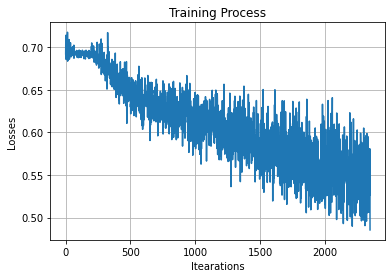

In [33]:
plt.title('Training Process')
plt.xlabel('Itearations')
plt.ylabel('Losses')
plt.grid()
plt.plot(losses)

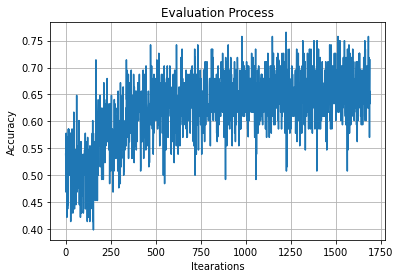

In [34]:
plt.title('Evaluation Process')
plt.xlabel('Itearations')
plt.ylabel('Accuracy')
plt.grid()
plt.plot(val_acc)

In [35]:
preds = []
true = []
for i, (texts, ys) in enumerate(test_iterator):   
    preds.extend(torch.argmax(model(texts), dim=1).cpu().detach().numpy())
    true.extend(ys.cpu().detach().numpy())
    
print(classification_report(true, preds))

              precision    recall  f1-score   support

           0       0.64      0.73      0.68     10756
           1       0.68      0.59      0.63     10755

    accuracy                           0.66     21511
   macro avg       0.66      0.66      0.66     21511
weighted avg       0.66      0.66      0.66     21511



## CNN 3/4/5 + Attention

In [36]:
import math

In [37]:
class LSTM_attention(torch.nn.Module):
      def __init__(self, vocab_size, n=2): #n - количетсво категорий len(word2id)

            super().__init__()

            self.n = n

            self.emb_layer = nn.Embedding(vocab_size, 300)

            self.LSTM = torch.nn.LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
            # задайте лстм, можно 2 уровня, лучше бидирекциональный, в доке торча есть инофрмация как это сделать в одну строчку

            self.q_proj = torch.nn.Linear(in_features=512, out_features=256, bias=True) # три линейных преобразования, размерность совпадает с выходом из лстм (если БИлстм то надо умножить ее на 2)
            self.k_proj = torch.nn.Linear(in_features=512, out_features=256, bias=True)
            self.v_proj = torch.nn.Linear(in_features=512, out_features=256, bias=True)

            self.att_soft = torch.nn.Softmax(dim = 2)

            self.cnn_3gr = torch.nn.Conv1d(256, 128, kernel_size=(3,), stride=(1,)) # три конволюционных фильтра с разными ядрами (3,4,5) чтобы были всякие нграммы ловить
            self.cnn_4gr = torch.nn.Conv1d(256, 128, kernel_size=(4,), stride=(1,))
            self.cnn_5gr = torch.nn.Conv1d(256, 128, kernel_size=(5,), stride=(1,))

            self.linear_1 = torch.nn.Linear(in_features=384, out_features=256, bias=True) # сверху накидываем два полносвязных слоя для классификации
            self.linear_added = torch.nn.Linear(in_features=256, out_features=256, bias=True) 
            self.relu = torch.nn.PReLU()
            self.dropout = torch.nn.Dropout(p=0.5)
            self.linear_2 = torch.nn.Linear(in_features=256, out_features=2, bias=True)


      def forward(self, x):
          x_emb = self.emb_layer(x) #примените эмбеддинги 
          # транспонируйте тензор для лстм как было описано выше
          x_lstm, _ = self.LSTM(x_emb) # применим лстм, не забываем что на выходе у него много всяких последовательностей, нам нужна только эта

          x_q = self.q_proj(x_lstm) # применим линейные преобразования для селф-эттеншена
          x_k = self.k_proj(x_lstm)
          x_v = self.v_proj(x_lstm)

          att_scores = torch.bmm(x_q, x_k.transpose(2, 1)) /  math.sqrt(x_q.size(-1))
          # посмотрите в презентацию и перемножьте нужные тензора изспольуя функцию bmm из торча, перед этим одну из матриц обзательно транспонируйте
          # результат обязательно поделите на корень из последней размерности (то есть на рземер эмбеддинга из предыдущего слоя)
          att_dist = self.att_soft(att_scores) # накидываем софтмакс
          attention_vectors = torch.bmm(att_dist, x_v) # тут тоже что то с чем то нужно перемножить :)

          x_att = attention_vectors.transpose(2, 1) #транспонируем для конфолючионнах фильтров

          x_cnn3 = self.cnn_3gr(x_att)
          x_cnn4 = self.cnn_4gr(x_att)
          x_cnn5 = self.cnn_5gr(x_att)

          frst, _ =  x_cnn3.max(dim= -1,) # cделаем макс пуллинг
          sc, _ = x_cnn4.max(dim= -1,)
          thr, _ = x_cnn5.max(dim= -1,)

          x_cat = torch.cat((frst, sc, thr), dim=-1) # а теперь объединим результаты

          x = self.linear_1(x_cat) # пару полносвязных слоев с релу для классификации
          x = self.dropout(self.relu(x))      
          x = self.linear_2(x)

          return x

In [39]:
model = LSTM_attention(vocab_size=len(word2id)) #drop_first, max_length, filter_sizes, vocab_size
model = model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(DEVICE)
scheduler = ExponentialLR(optimizer, gamma=0.7)
losses, val_losses, val_losses_epoch, val_acc, val_acc_epoch = train_scheduler(model, train_iterator, test_iterator, optimizer, criterion, 7)

Training ... 


Epoch 1:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 1:   0%|          | 0/21511 [00:00<?, ?it/s]

Training ... 


Epoch 2:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 2:   0%|          | 0/21511 [00:00<?, ?it/s]

Training ... 


Epoch 3:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 3:   0%|          | 0/21511 [00:00<?, ?it/s]

Training ... 


Epoch 4:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 4:   0%|          | 0/21511 [00:00<?, ?it/s]

Training ... 


Epoch 5:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 5:   0%|          | 0/21511 [00:00<?, ?it/s]

Training ... 


Epoch 6:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 6:   0%|          | 0/21511 [00:00<?, ?it/s]

Training ... 


Epoch 7:   0%|          | 0/30000 [00:00<?, ?it/s]

Validating ... 


Epoch 7:   0%|          | 0/21511 [00:00<?, ?it/s]

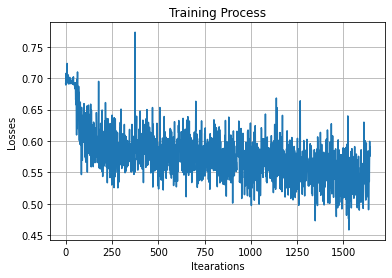

In [40]:
plt.title('Training Process')
plt.xlabel('Itearations')
plt.ylabel('Losses')
plt.grid()
plt.plot(losses)

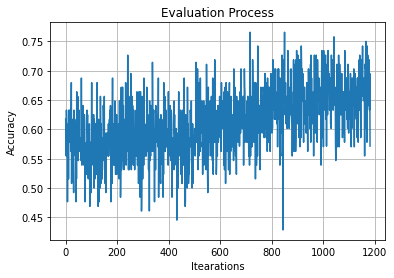

In [41]:
plt.title('Evaluation Process')
plt.xlabel('Itearations')
plt.ylabel('Accuracy')
plt.grid()
plt.plot(val_acc)

In [42]:
preds = []
true = []
for i, (texts, ys) in enumerate(test_iterator):   
    preds.extend(torch.argmax(model(texts), dim=1).cpu().detach().numpy())
    true.extend(ys.cpu().detach().numpy())
    
print(classification_report(true, preds))

              precision    recall  f1-score   support

           0       0.63      0.78      0.70     10756
           1       0.71      0.53      0.61     10755

    accuracy                           0.66     21511
   macro avg       0.67      0.66      0.65     21511
weighted avg       0.67      0.66      0.65     21511

